# Module 3: Observation Simulation

## Purpose
Apply realistic observation effects including PSF convolution, detector noise, and observing strategy to create data that matches what HWO would actually observe.

In [1]:
import sys
import numpy as np
import autolens as al
import matplotlib.pyplot as plt
from pathlib import Path

# Add hwoslaps to path
sys.path.insert(0, '/path/to/hwo-slaps/src')

# Import the generators
from hwoslaps.lensing import generate_lensing_system
from hwoslaps.psf import generate_psf_system
from hwoslaps.psf.utils import print_psf_data_summary
from hwoslaps.lensing.utils import print_lensing_data_summary

2025-07-14 14:13:36,288 - numexpr.utils - INFO - NumExpr defaulting to 16 threads.


In [2]:
# CELL 1: Load the master configuration & generate the PSF system
import yaml
config_path = '/Users/vassilak/research/hwo/hwo-slaps/configs/master_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

In [3]:
# Generate the data structures
print("Generating lensing system...")
lensing_data = generate_lensing_system(config['lensing'], full_config=config)
print_lensing_data_summary(lensing_data)

Generating lensing system...
=== Lensing System Summary ===
Pixel scale: 0.050000 arcsec/pixel
Grid shape: (201, 201)
Field of view: 10.05 x 10.05 arcsec
Cosmology: Planck15

=== Lens Galaxy ===
Redshift: 0.5
Einstein radius: 1.600000 arcsec
Centre: (0.000000, 0.000000) arcsec
Ellipticity: e1=0.100, e2=0.000

=== Source Galaxy ===
Redshift: 1.0
Centre: (0.300000, 0.200000) arcsec
Ellipticity: e1=0.100, e2=0.000
Effective radius: 0.500000 arcsec
Intensity: 0.100000

=== Subhalo Properties ===
Model: SIS
Mass: 1.00e+08 M_sun
Einstein radius: 0.000325 arcsec
Position: (1.131371, 1.131371) arcsec
Distance from lens: 1.600000 arcsec
Position angle: 45.0 degrees
Distance/Einstein radius: 1.000

=== Image Statistics ===
Total flux: 9.344622e+02
Peak intensity: 5.122695e-01
Min intensity: 7.094512e-10
Mean intensity: 2.312968e-02
RMS: 6.478402e-02

Generated: 2025-07-14T14:13:37.158539
Run name: psf_downsizing


In [4]:
print("\nGenerating PSF system...")
psf_data = generate_psf_system(config['psf'], full_config=config)
print_psf_data_summary(psf_data)


Generating PSF system...
Auto-adjusting PSF sampling: requested=5, used=5.0241 to achieve integer subsampling of N=22.
=== PSF System Summary ===
Telescope diameter: 7.2 m
Number of segments: 19
Wavelength: 400 nm
F-number: 19.9
Pixel scale: 0.002273 arcsec/pixel

=== Diverging-Path Sampling ===
Requested sampling: 5.00 pixels/λ/D
Auto-adjusted sampling: 5.024 pixels/λ/D
Integer subsampling factor: 22
High-res pixel scale: 2.273 mas
Detector pixel scale: 50.000 mas

=== Physical Scales ===
Diffraction limit: 0.011418 arcsec
Angular resolution: 11.4 mas
Airy disk diameter: 0.027861 arcsec

=== PSF Quality ===
FWHM: 5.324435 arcsec (5324.4 mas)
Peak intensity: 7.052522e+15
Total flux: 2.694135e+17

=== PyAutoLens Kernel Statistics ===
Kernel shape: (120, 120)
Kernel pixel scale: 0.050000 arcsec/pixel
Total flux: 1.000000
Peak value: 2.617731e-02
Min value: 8.874997e-15
Central pixel fraction: 2.62%
Flux in central 3x3: 21.1%
Flux in central 5x5: 47.5%
Pixels > peak/1000: 1187
Pixels > p

PSF kernel shape: (120, 120)
Fixed PSF kernel shape: (119, 119)


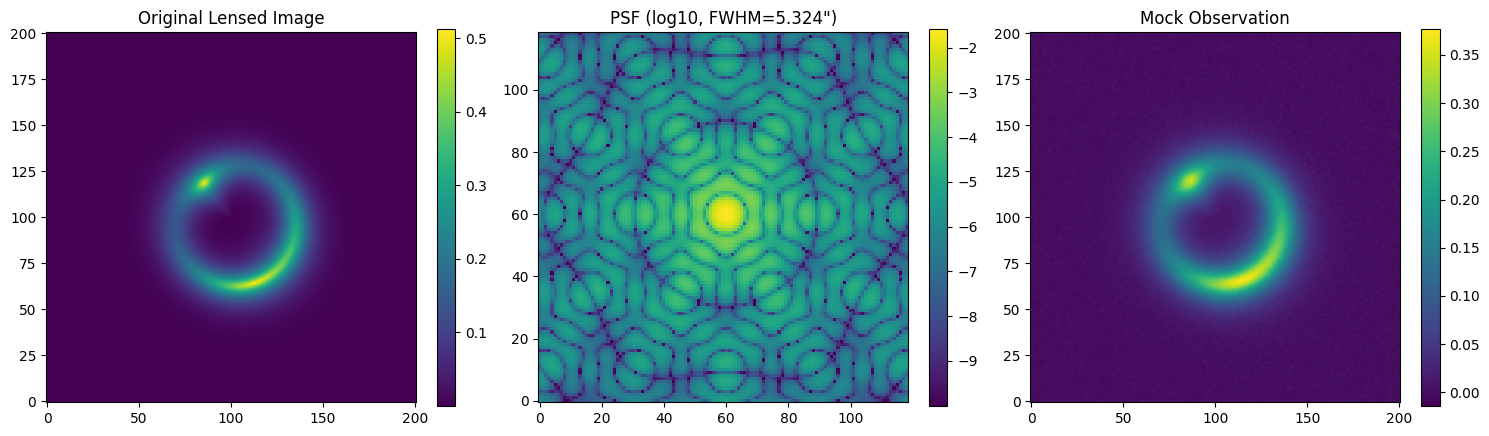


Mock observation created:
  Image shape: (201, 201)
  Pixel scale: 0.05 arcsec/pixel
  Peak SNR: 101.6
  Total flux: 9.35e+02 electrons

Subhalo properties:
  Mass: 1.00e+08 M_sun
  Position: (1.131370849898476, 1.1313708498984762)
  Einstein radius: 0.000325 arcsec


In [5]:
# Check the current kernel dimensions
print(f"PSF kernel shape: {psf_data.kernel.shape_native}")

# Fix kernel to have odd dimensions
kernel_array = psf_data.kernel.native

# Ensure odd dimensions
if kernel_array.shape[0] % 2 == 0 or kernel_array.shape[1] % 2 == 0:
    if kernel_array.shape[0] % 2 == 0:
        kernel_array = kernel_array[:-1, :]
    if kernel_array.shape[1] % 2 == 0:
        kernel_array = kernel_array[:, :-1]
    
    psf_kernel_odd = al.Kernel2D.no_mask(
        values=kernel_array,
        pixel_scales=psf_data.kernel.pixel_scales,
        normalize=True
    )
else:
    psf_kernel_odd = psf_data.kernel

print(f"Fixed PSF kernel shape: {psf_kernel_odd.shape_native}")

# Convert lensed image to PyAutoLens Array2D format
mask = al.Mask2D.all_false(
    shape_native=lensing_data.image.shape,
    pixel_scales=lensing_data.pixel_scale
)

lensed_image = al.Array2D(
    values=lensing_data.image,
    mask=mask
)

# Create the simulator
simulator = al.SimulatorImaging(
    exposure_time=100000.0,
    psf=psf_kernel_odd,
    background_sky_level=1,
    normalize_psf=True,
    add_poisson_noise_to_data=True,
    noise_seed=1
)

# Generate the mock observation
mock_dataset = simulator.via_image_from(
    image=lensed_image
)

# Quick visualization - use .native for 2D arrays
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original lensed image
im1 = axes[0].imshow(lensing_data.image, origin='lower')
axes[0].set_title('Original Lensed Image')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# PSF (log scale)
psf_native = psf_kernel_odd.native
# Add a small value to avoid log(0)
log_psf = np.log10(psf_native + 1e-10)
im2 = axes[1].imshow(log_psf, origin='lower')
axes[1].set_title(f'PSF (log10, FWHM={psf_data.fwhm_arcsec:.3f}")')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# Mock observation - use .native to get 2D array
im3 = axes[2].imshow(mock_dataset.data.native, origin='lower')
axes[2].set_title('Mock Observation')
plt.colorbar(im3, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

# Print summary information
print(f"\nMock observation created:")
print(f"  Image shape: {mock_dataset.data.shape_native}")
print(f"  Pixel scale: {lensing_data.pixel_scale} arcsec/pixel")
print(f"  Peak SNR: {np.max(mock_dataset.signal_to_noise_map):.1f}")
print(f"  Total flux: {np.sum(mock_dataset.data):.2e} electrons")

if lensing_data.has_subhalo:
    print(f"\nSubhalo properties:")
    print(f"  Mass: {lensing_data.subhalo_mass:.2e} M_sun")
    print(f"  Position: {lensing_data.subhalo_position}")
    print(f"  Einstein radius: {lensing_data.subhalo_einstein_radius:.6f} arcsec")

## Add camera noise functionality

In [6]:
# Cell: Define Detector Parameters
# === DETECTOR PARAMETERS ===
DETECTOR_CONFIG = {
    'gain': 1.0,              # e-/ADU
    'read_noise': 5.0,        # e-/pixel
    'dark_current': 0.001,    # e-/pixel/s
    'sky_background': 1.0,    # e-/pixel/s (same as your original)
}

print(f"Detector parameters for realistic noise:")
for key, value in DETECTOR_CONFIG.items():
    print(f"  {key}: {value}")
    
# Cell: Generate Noiseless PSF-Convolved Image
# Use SimulatorImaging to get PSF convolution but no noise
simulator_noiseless = al.SimulatorImaging(
    exposure_time=1000.0,
    psf=psf_kernel_odd,
    background_sky_level=0.0,  # No background yet
    normalize_psf=True,
    add_poisson_noise_to_data=False,
    noise_seed=1
)

# Get noiseless but PSF-convolved image (source only)
noiseless_dataset = simulator_noiseless.via_image_from(image=lensed_image)
source_only_eps = noiseless_dataset.data.native  # e-/s

print(f"Source-only image (PSF-convolved): max = {np.max(source_only_eps):.3f} e-/s")

Detector parameters for realistic noise:
  gain: 1.0
  read_noise: 5.0
  dark_current: 0.001
  sky_background: 1.0
Source-only image (PSF-convolved): max = 0.372 e-/s


In [7]:
# Cell: Apply Realistic Detector Noise
np.random.seed(1)  # For reproducibility

# Convert to total electrons for each component
exposure_time = 1000.0
source_e = source_only_eps * exposure_time
dark_e = DETECTOR_CONFIG['dark_current'] * exposure_time  # Per pixel
sky_e = DETECTOR_CONFIG['sky_background'] * exposure_time  # Per pixel

# Total expected electrons per pixel
expected_e = source_e + dark_e + sky_e

# Apply Poisson noise to the total expected counts
detected_e = np.random.poisson(expected_e)

# Add read noise
final_e = detected_e + np.random.normal(0, DETECTOR_CONFIG['read_noise'], 
                                       size=detected_e.shape)

# Convert to ADU
final_image_adu = final_e / DETECTOR_CONFIG['gain']

print(f"Signal levels:")
print(f"  Max source: {np.max(source_e):.0f} e-")
print(f"  Sky per pixel: {sky_e:.0f} e-")
print(f"  Dark per pixel: {dark_e:.1f} e-")

Signal levels:
  Max source: 372 e-
  Sky per pixel: 1000 e-
  Dark per pixel: 1.0 e-


Signal levels:
  Max source: 372 e-
  Sky per pixel: 1000 e-
  Dark per pixel: 1.0 e-

Noise map statistics:
  Min noise: 32.0 ADU (dark regions)
  Max noise: 37.4 ADU (bright regions)
  Background-dominated noise: ~32.0 e-


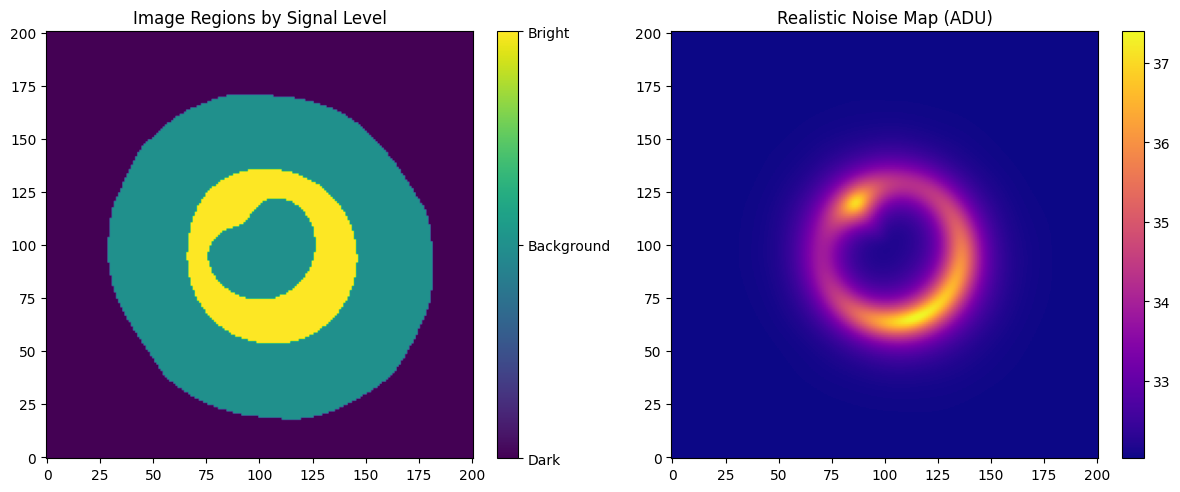

Noise by region (in electrons):
  Dark regions: 32.0 e-
  Background-dominated: 32.3 e-
  Bright regions: 34.7 e-

Theoretical noise (in electrons):
  Dark: sqrt(1001.0 + 25.0) = 32.0 e-
  Bright (if 500 e- source): sqrt(1501.0 + 25.0) = 39.1 e-


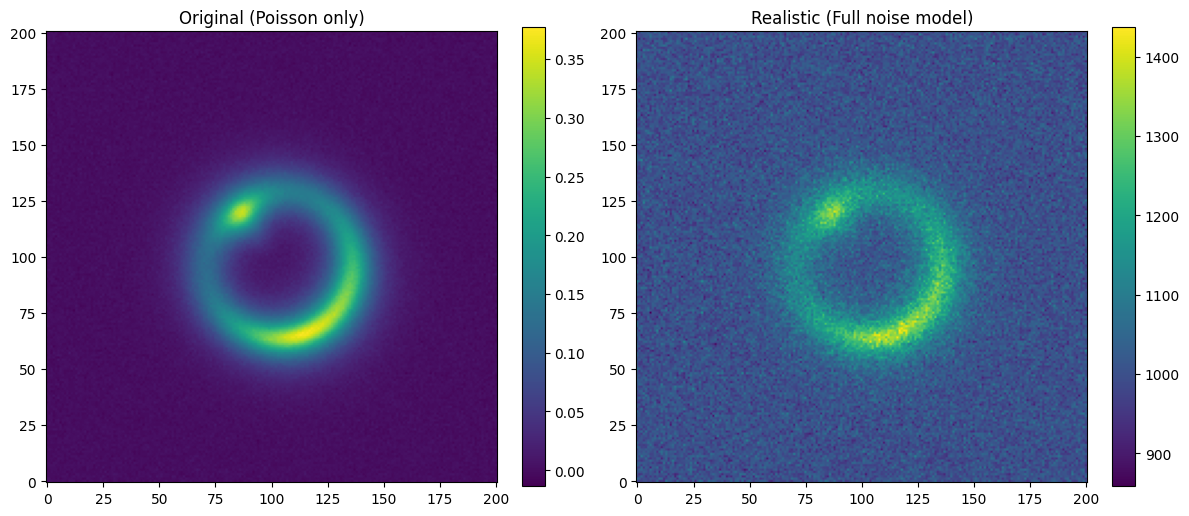

Noise ratio statistics:
  Mean: 10126.4721
  Std: 16.8664
  Min: 10053.6827 (bright regions)
  Max: 10199.6267 (dark regions)


In [8]:
# Cell: Apply Realistic Detector Noise
np.random.seed(1)  # For reproducibility

# Convert to total electrons for each component
exposure_time = 1000.0
source_e = source_only_eps * exposure_time
dark_e = DETECTOR_CONFIG['dark_current'] * exposure_time  # Per pixel
sky_e = DETECTOR_CONFIG['sky_background'] * exposure_time  # Per pixel

# Total expected electrons per pixel
expected_e = source_e + dark_e + sky_e

# Apply Poisson noise to the total expected counts
detected_e = np.random.poisson(expected_e)

# Add read noise
final_e = detected_e + np.random.normal(0, DETECTOR_CONFIG['read_noise'], 
                                       size=detected_e.shape)

# Convert to ADU
final_image_adu = final_e / DETECTOR_CONFIG['gain']

print(f"Signal levels:")
print(f"  Max source: {np.max(source_e):.0f} e-")
print(f"  Sky per pixel: {sky_e:.0f} e-")
print(f"  Dark per pixel: {dark_e:.1f} e-")

# Cell: Create Proper Noise Map
# The noise map represents the total uncertainty in each pixel

# Variance components (in electrons²):
# - Poisson variance = expected counts (source + sky + dark)
# - Read noise variance = read_noise²
total_variance_e2 = expected_e + DETECTOR_CONFIG['read_noise']**2

# Convert to noise in ADU
noise_map_adu = np.sqrt(total_variance_e2) / DETECTOR_CONFIG['gain']

# Create PyAutoLens arrays
mask = al.Mask2D.all_false(
    shape_native=final_image_adu.shape,
    pixel_scales=lensing_data.pixel_scale
)

data = al.Array2D(values=final_image_adu, mask=mask)
noise_map = al.Array2D(values=noise_map_adu, mask=mask)

# Create realistic imaging dataset
realistic_dataset = al.Imaging(
    data=data,
    noise_map=noise_map,
    psf=psf_kernel_odd
)

print(f"\nNoise map statistics:")
print(f"  Min noise: {np.min(noise_map_adu):.1f} ADU (dark regions)")
print(f"  Max noise: {np.max(noise_map_adu):.1f} ADU (bright regions)")
print(f"  Background-dominated noise: ~{np.sqrt(sky_e + dark_e + DETECTOR_CONFIG['read_noise']**2):.1f} e-")

# Cell: Analyze Noise Components
# Let's examine how noise varies across the image

# Define regions by signal level
very_dark = source_only_eps < 0.001  # Essentially no source
background_dominated = (source_only_eps >= 0.001) & (source_only_eps < 0.1)
bright = source_only_eps >= 0.1

# Calculate expected noise in each region
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Show regions
region_map = np.zeros_like(source_only_eps)
region_map[very_dark] = 1
region_map[background_dominated] = 2
region_map[bright] = 3
im1 = ax1.imshow(region_map, origin='lower', cmap='viridis')
ax1.set_title('Image Regions by Signal Level')
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046)
cbar1.set_ticks([1, 2, 3])
cbar1.set_ticklabels(['Dark', 'Background', 'Bright'])

# Right: Noise map
im2 = ax2.imshow(noise_map_adu, origin='lower', cmap='plasma')
ax2.set_title('Realistic Noise Map (ADU)')
plt.colorbar(im2, ax=ax2, fraction=0.046)

plt.tight_layout()
plt.show()

# Print noise statistics by region
print("Noise by region (in electrons):")
print(f"  Dark regions: {np.mean(noise_map_adu[very_dark] * DETECTOR_CONFIG['gain']):.1f} e-")
print(f"  Background-dominated: {np.mean(noise_map_adu[background_dominated] * DETECTOR_CONFIG['gain']):.1f} e-")
print(f"  Bright regions: {np.mean(noise_map_adu[bright] * DETECTOR_CONFIG['gain']):.1f} e-")

# Theoretical expectations
print(f"\nTheoretical noise (in electrons):")
print(f"  Dark: sqrt({sky_e + dark_e:.1f} + {DETECTOR_CONFIG['read_noise']**2:.1f}) = {np.sqrt(sky_e + dark_e + DETECTOR_CONFIG['read_noise']**2):.1f} e-")
print(f"  Bright (if 500 e- source): sqrt({500 + sky_e + dark_e:.1f} + {DETECTOR_CONFIG['read_noise']**2:.1f}) = {np.sqrt(500 + sky_e + dark_e + DETECTOR_CONFIG['read_noise']**2):.1f} e-")

# Cell: Compare with Original PyAutoLens Noise
# Now let's properly compare with the original

# The original includes sky background, so its noise in dark regions is:
# sqrt(sky) ≈ sqrt(1000) ≈ 31.6 e-
# Our realistic model in dark regions is:
# sqrt(sky + dark + read²) ≈ sqrt(1001 + 25) ≈ 32.0 e-

fig, axes = plt.subplots(1, 2, figsize=(12, 10))

# Top left: Original image
im1 = axes[0].imshow(mock_dataset.data.native, origin='lower', cmap='viridis')
axes[0].set_title('Original (Poisson only)')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Top right: Realistic image
im2 = axes[1].imshow(realistic_dataset.data.native, origin='lower', cmap='viridis')
axes[1].set_title('Realistic (Full noise model)')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# Bottom left: Noise maps comparison
noise_ratio = realistic_dataset.noise_map.native / mock_dataset.noise_map.native

plt.tight_layout()
plt.show()

print(f"Noise ratio statistics:")
print(f"  Mean: {np.mean(noise_ratio):.4f}")
print(f"  Std: {np.std(noise_ratio):.4f}")
print(f"  Min: {np.min(noise_ratio):.4f} (bright regions)")
print(f"  Max: {np.max(noise_ratio):.4f} (dark regions)")